In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import boston_housing
from sklearn import datasets
from tensorflow.keras.utils import to_categorical

# -1. Matrices, Gradients, Hessians

Given the function $f(x1, x2) = (1 - x1)^2 + 5 (x2 - x1^2)^2$, compute:

### a) Gradient $\nabla f(1, 1)$


$\nabla f_{x1}(x1, x2) = 2(1-x1)(-1) + 10(x2 - x1^2)(-2x1) = 2(x1-1) -20x1(x2-x1^2)$

$\nabla f_{x1}(1, 1) = 0$

$\nabla f_{x2}(x1, x2) = 10(x2 - x1^2)$

$\nabla f_{x2}(1, 2) = 0$

$\nabla f(1, 1) = [0, 0]$

### b) Hessian $\nabla^2 f(1, 1)$

$\nabla f_{x1x1}(x1, x2) = 2 - 20(x2 - x1^2) - 20x1(-2x1) = 2 - 20(x2 - x1^2) + 40x1^2 = 2 - 20x2 + 60x1^2$

$\nabla f_{x1x1}(1, 1) = 42 $

$\nabla f_{x1x2}(x1, x2) = -20x1$

$\nabla f_{x1x2}(1, 1) = -20 $

$\nabla f_{x2x2}(x1, x2) = 10x2$

$\nabla f_{x2x2}(1, 1) = 10$

$\nabla f_{x2x1}(x1, x2) = 10(- 2x1) = -20x1$

$\nabla f_{x2x1}(1, 1) = -20$

So the Hessian matrix is:

$
\begin{pmatrix}
42 & -20 \\
-20 & 10
\end{pmatrix}
$

### c) Is the hessian positive definite? Why?

##### Using $p^T H P > 0$

$
\begin{pmatrix}
1 & 1
\end{pmatrix}
\begin{pmatrix}
42 & -20 \\
-20 & 10
\end{pmatrix}
\begin{pmatrix}
1 \\ 1
\end{pmatrix} = \begin{pmatrix}
22 & -10
\end{pmatrix}
\begin{pmatrix}
1 \\ 1
\end{pmatrix} = 22-10 = 12 >0
$

So Hessian is positive definite

# Neural Network

In [15]:
import numpy as np

In [11]:
def initialize_weights(shapes, outputs):
  """Initializes weights of model according to shape.

     Args:
       shapes = [784, 300, 10]
       outputs = ["relu", "sigmoid"]
     returns:
       model with uniform random weights [-1,+1], zero bias and output function
       [
        [random(784, 300), zeros(300), "relu"]
        [random(300, 10), zeros(10), "sigmoid"] 
      ]
  """
  models = []
  for i in range(len(shapes)):
    if i is 0:
      continue

    models.append([
      np.random.uniform(-1, 1, (shapes[i - 1], shapes[i])),
      np.zeros(shapes[i]).reshape(1, shapes[i]),
      outputs[i - 1]
    ])

  return models

<>:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/lp/d6rvxqjj3kz6lttqxb7ll4080000gn/T/ipykernel_77121/732425968.py:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if i is 0:


In [99]:
def relu(x):
  """Computes relu of function."""
  return np.maximum(0, x)

def sigmoid(x):
  """Computes sigmoid of function."""
  return 1 / (1 + np.exp(-x))

def relu_derivative(z):
  """Computes derivative of relu of function."""
  z_copy = np.array(z, copy=True)
  z_copy[z_copy <= 0] = 0
  z_copy[z_copy > 0] = 1
  return z_copy

def sigmoid_derivative(z):
  """Computes derivative of sigmoid of function."""
  sig = sigmoid(z)
  return sig * (1 - sig)

def linear(x):
  """Return linear function of itself."""
  return x

def d_linear(x):
    # differential of linear function
    return np.ones_like(x)

In [61]:
def activate(z, funcName):
  """Activate the given input based on activation function name
  
     Args:
       z: input tensor of shape (B, Ni)
       funcName: string of supported activation function name
     Returns:
       tensor of shape (B, Ni) after applied activation function
  """
  supported_funcs = {
    "relu": relu,
    "sigmoid": sigmoid,
    "linear": lambda x: x
  }

  if funcName not in supported_funcs:
    raise Exception("Unsupported function")

  return supported_funcs[funcName](z)
  

def forward(x, model):
  """Performs forward pass of training step.

     Args:
       x: input tensor of shape (B, Ni)
       model: list of model weights (see initialize weights)
     Returns:
       List containing dictionary { "y": y, "z": z } for each layer of network.
  """     

  # Add input as first layer, which will be consumed in backward
  layer_output = [{"z": x, "y": x}]

  for w, b, activation_func in model:
    y_prev = layer_output[-1]["y"]
    
    z = np.dot(y_prev, w) + b
    y = activate(z, activation_func)
    
    layer_output.append({"z": z, "y": y})

  return layer_output

In [62]:
def predict(x, model):
  """Predicts the output of a model.

     Args:
       x: input tensor of shape (B, Ni)
       model: list of model weights (see initialize weights)
     Returns:
       Prediction of model, with the same shape as the labeled data (B, No).
  """
  fwd = forward(x, model)
  return fwd[-1]["y"]

In [63]:
def mse(y, p):
  """Computes Mean-Square Error between y and p.
     Args:
       y: labeled data of size (B, No) 
       p: predicted label of size (B, No)
     Returns:
       MSE of y-p
  """
  return np.mean(np.square(y-p))

def mse_derivative(y, p):
  """Computes derivative of Mean-Square Error between y and p.
     Args:
       y: labeled data of size (B, No) 
       p: predicted label of size (B, No)
     Returns:
       derivative of MSE = y-p
  """
  return p-y

In [64]:
def binary_crossentropy(y, p):
  """Computes binary crossentropy between y and p.
     Args:
       y: labeled data of size (B, No) 
       p: predicted label of size (B, No)
     Returns:
       BCE of (y, p) = mean(sum(y log(p) + (1-y) log(1-p))) 
  """
  return -np.mean(y * np.log(p) + (1-y) * np.log(1-p))

def binary_crossentropy_derivative(y, p):
  """Computes derivative of binary crossentropy between y and p.
     Args:
       y: labeled data of size (B, No) 
       p: predicted label of size (B, No)
     Returns:
       derivative of BCE of (y, p) = -[y / p - (1-y) / (1-p)]
  """
  return -((y / p) - np.divide(1-y, 1-p))

In [65]:
def get_cost(y, p, funcName, is_last_layer_error=False):
  """Calculate lost based on cost function name.
  
     Args:
       y: input tensor of shape (B, Ni)
       p: label vector of shape (B, 1)
       funcName: string of supported lost function name
     Returns:
       tensor of shape (B, Ni) after applied cost function
  """
  supported_cost_funcs = {
    "mse": mse,
    "binary_crossentropy": binary_crossentropy,
  }
    
  supported_cost_funcs_derivative = {
    "mse": mse_derivative,
    "binary_crossentropy": binary_crossentropy_derivative,
  }

  # Should also appear in supported_cost_funcs_derivative 
  if funcName not in supported_cost_funcs:
    raise Exception("Unsupported function")

  func = supported_cost_funcs_derivative if is_last_layer_error else supported_cost_funcs

  return func[funcName](y, p)

def get_activation_derivative(z, funcName):
  """Computes derivative of activation function for computing dZ.
     Args:
       z: input tensor of shape (B, Ni)
       funcName: string of supported activation function name
     Returns:
       derivative of activation function
  """
  supported_funcs = {
    "relu": relu_derivative,
    "sigmoid": sigmoid_derivative,
    "linear": lambda _: 1
  }

  if funcName not in supported_funcs:
    raise Exception("Unsupported function")

  return supported_funcs[funcName](z)

def backward(y, x, models, loss):
  """Computes backward step of training.
     Args:
       y: labeled data of size (B, No) 
       x: input tensor of shape (B, Ni)
       model: list of model weights (see initialize weights)
       loss: one of ("mse", "binary_crossentropy")
     Returns:
       tuple with loss evaluation of (y, predict(x)) and list of dictionary
       containing { "dw": dw, "db": db } for each layer of network. Remember
       that shape of dw for each layer should be equal to shape of weight for
       the same layer.
  """
  y_predicted = x[-1]["y"]
  y = y.reshape(y_predicted.shape)
  b = y.shape[0] # number of training data

  cost = get_cost(y, y_predicted, loss)
  weights = []

  dY_prev = get_cost(y, y_predicted, loss, is_last_layer_error=True)

  for i, model in reversed(list(enumerate(models))):
    dY_curr = dY_prev

    Y_prev = x[i]["y"]
    Z_curr = x[i + 1]["z"]
    W_curr, _, activation_func = model
    
    dZ_curr = get_activation_derivative(Z_curr, activation_func) * dY_curr
    dW_curr = np.dot(Y_prev.T, dZ_curr) / b
    db_curr = np.sum(dZ_curr, axis=0, keepdims=True) / b
    dY_prev = np.dot(dZ_curr, W_curr.T)

    weights.insert(0, {"dw": dW_curr, "db": db_curr})

  return (cost, weights)

In [66]:
def update(weights, dweights, alpha):
  """Gradient descent for weights and biases."""
  for i in range(len(weights)):
    weights[i][0] += - alpha * dweights[i]["dw"]
    weights[i][1] += - alpha * dweights[i]["db"]

#  Regression: BOSTON dataset

In [67]:
import numpy as np

from keras.datasets import boston_housing
from sklearn.preprocessing import normalize

In [68]:
def load_data():
  (x_train, y_train), (x_test, y_test) = boston_housing.load_data()

  # condition data to be in a format you need to use

  x_train = normalize(x_train, norm='max', axis=0)
  x_test = normalize(x_test, norm='max', axis=0)
    
  return (x_train, y_train), (x_test, y_test)

In [69]:
import matplotlib.pyplot as plt

%matplotlib inline 

def plot_loss(losses, test_loss, epochs):
  fig, ax = plt.subplots()
  time = np.arange(0, epochs, 1)
  ax.plot(time, losses)

  # test loss
  y = test_loss
  plt.axhline(y=y, color="orange")
  text = 'test loss: ' + str(np.around(y, decimals=3))
  plt.annotate(text, xy=(2, y), xytext=(3, y+50),
    arrowprops=dict(facecolor='black', shrink=0.05),
  )

  ax.set(xlabel='iteration', ylabel='loss',
       title='Loss over time')
  plt.show()

In [70]:
def main():
  (x_train, y_train), (x_test, y_test) = load_data()
    
  # linear network
  # plot training and test loss over time in jupyter notebook

  shapes = [x_train.shape[1], 1]
  outputs = ["linear"]
  model = initialize_weights(shapes, outputs)

  train_losses = []

  # what's the alpha you should use?

  alpha = 0.3
  epochs = 300
    
  # Training Set
  for i in range(epochs):
    fwd_results = forward(x_train, model)
    loss, dweights = backward(y_train, fwd_results, model, "mse")
    update(model, dweights, alpha)
    train_losses.append(loss)

  # Test Set
  test_results = forward(x_test, model)
  test_loss, _ = backward(y_test, test_results, model, "mse")

  # Plot
  plot_loss(train_losses, test_loss, epochs)

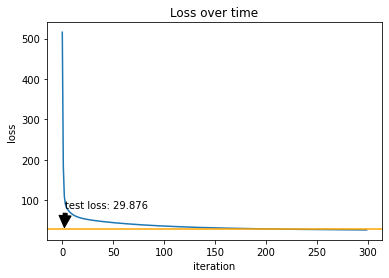

In [71]:
if __name__ == "__main__":
  main()

#  Classification : IRIS dataset

In [72]:
import numpy as np

from sklearn import datasets
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

In [73]:
def load_iris():
  iris = datasets.load_iris()
  x = iris.data.astype(np.float32)
  y = iris.target

  y = to_categorical(y, np.max(y)+1).astype(np.float32)

  # need to do conditioning on the dataset

  x_train, x_test, y_train, y_test = train_test_split(x, y)
  x_train = normalize(x_train, norm='max', axis=0)
  x_test = normalize(x_test, norm='max', axis=0)

  return (x_train, y_train), (x_test, y_test)

In [74]:
import matplotlib.pyplot as plt

%matplotlib inline 

def plot_loss(losses, test_loss, epochs):
  fig, ax = plt.subplots()
  time = np.arange(0, epochs, 1)
  ax.plot(time, losses)

  # test loss
  y = test_loss
  plt.axhline(y=y, color="orange")
  text = 'test loss: ' + str(np.around(y, decimals=3))
  plt.annotate(text, xy=(2, y), xytext=(3, y * 1.05),
    arrowprops=dict(facecolor='black', shrink=0.05),
  )

  ax.set(xlabel='iteration', ylabel='loss',
       title='Loss over time')
  plt.show()
    
def plot_accuracy(accuracies, test_accuracy, epochs):
  fig, ax = plt.subplots()
  time = np.arange(0, epochs, 1)
  ax.plot(time, accuracies)

  # test accuracy
  y = test_accuracy
  plt.axhline(y=y, color="orange")
  text = 'test accuracy: ' + str(np.around(y, decimals=3))
  plt.annotate(text, xy=(2, y), xytext=(3, y * 0.95),
    arrowprops=dict(facecolor='black', shrink=0.05),
  )

  ax.set(xlabel='iteration', ylabel='accuracy',
       title='Accuracy over time')
  plt.show()


In [75]:
def main():
  (x_train, y_train), (x_test, y_test) = load_iris()

  # example of network. try your own to get higher accuracy
  # plot training and test loss over time in jupyter notebook
  # plot training and test accuracy over time in jupyter notebook 

  outputs = ["relu", "relu", "sigmoid"]
  shapes = [x_train.shape[1], 30, 10, y_train.shape[1]]

  train_losses = []
  train_accuracies = []
    
  # which alpha should you use?
  alpha = 0.02
  model = initialize_weights(shapes, outputs)
  labels = np.argmax(y_train, axis=1)
  epochs = 100

  # Training
  for i in range(epochs):
    fwd_results = forward(x_train, model)
    loss, dweights = backward(y_train, fwd_results, model, "binary_crossentropy")
    update(model, dweights, alpha)
    
    prediction = predict(x_train, model)
    prediction = np.argmax(prediction, axis=1)
    
    accuracy = np.divide(np.sum(prediction==labels), labels.shape[0])
    accuracy = np.around(accuracy, decimals=3)
    
    train_accuracies.append(accuracy)
    train_losses.append(loss)
    
  # Test Set
  test_results = forward(x_test, model)
  test_loss, _ = backward(y_test, test_results, model, "binary_crossentropy")
  prediction = test_results[-1]["y"]
  prediction = np.argmax(prediction, axis=1)
    
  test_labels = np.argmax(y_test, axis=1)
  test_accuracy = np.divide(np.sum(prediction==test_labels), test_labels.shape[0])
  test_accuracy = np.around(test_accuracy, decimals=3)

  # Plot
  plot_loss(train_losses, test_loss, epochs)
  plot_accuracy(train_accuracies, test_accuracy, epochs)

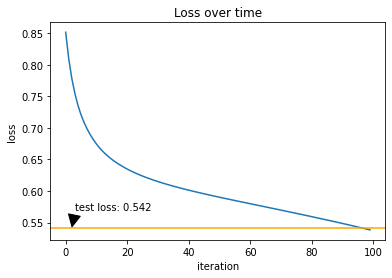

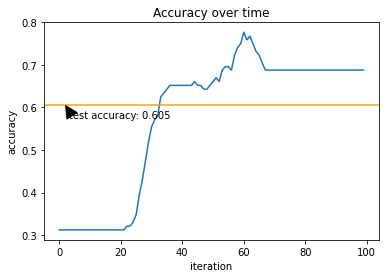

In [76]:
if __name__ == "__main__":
  main()